## Yahoo Movie Reviews

This notebook uses the fastai library and ULMFit to classify sentiment on Japanese Movie Reviews 

In [1]:
from fastai.text import *
import html

In [2]:
BOS = 'xbos'  # beginning-of-sentence tag
FLD = 'xfld'  # data field tag

PATH=Path('data/lm/')

## Standardize format

In [3]:
LM_PATH=Path('data/lm/yahoo_lm/')
#LM_PATH.mkdir(exist_ok=True)

In [4]:
import re
import MeCab

tagger = MeCab.Tagger("-Owakati")


def tokenize(raw_sentence):
    # http://testpy.hatenablog.com/entry/2016/10/04/010000
    #print(type(raw_sentence))
    result = tagger.parse(raw_sentence)
    words = result.split()
    if len(words) == 0:
        return ""
    if words[-1] == "\n":
        words = words[:-1]
    return ' '.join(words)

def tokenize_all(ss):
    new_ss = []
    for i in range(len(ss)):
        new_ss.append(tokenize(ss[i]))
        #print("Tokenizing {}/{} doc".format(i,len(ss)))
    return new_ss

def multi_core_tokenize(ss, ncpus=None):
    num_cpus=multiprocessing.cpu_count()
    ncpus = ncpus or num_cpus
    with ProcessPoolExecutor(ncpus) as e:
        return sum(e.map(tokenize_all, ss), [])

def get_char_str(astring):
    morphs = [c for c in astring if not re.search(r"^[\s\t\n]*$", c)]
    return " ".join(morphs)


### Prepare Data
Utility functions for processing obtained from https://github.com/dennybritz/sentiment-analysis/blob/master/utils/ymr_data.py

In [5]:
def load_ymr_data(path):
    with path.open() as f:
        data = pd.read_json(f)
        data.movieName = data.movieName.str.strip()
        data.text = data.text.str.strip()
        data.title = data.title.str.strip()
        data = data[data.text.str.len() > 0]
        data.url = data.url.str.strip()
    return data

def make_polar(data, balance=True):
    data_polar = data.loc[data.rating != 3].copy()
    data_polar.loc[data_polar.rating <= 2, 'rating'] = 0
    data_polar.loc[data_polar.rating >= 4, 'rating'] = 1
    if balance:
        # Subsample - We want the same number of positive and negative examples
        grouped_ratings = data_polar.groupby('rating')
        K = grouped_ratings.rating.count().min()
        indices = itertools.chain(
            *[np.random.choice(v, K, replace=False) for k, v in grouped_ratings.groups.items()])
        data_polar = data_polar.reindex(indices).copy()
    return data_polar


mov_df = load_ymr_data(PATH/'yahoo-movie-reviews.json')
mov_df_polar = make_polar(mov_df)
mov_df_polar.to_csv(LM_PATH/'mov_polar.csv', header=True, index=False, columns=['text', 'rating'])
#val_texts,val_labels = get_texts(PATH/'test')

In [6]:
mov_df_polar.head()

,date,movieName,movieUrl,rating,text,title,url
42685,2007年9月26日 7時52分,トランスフォーマー,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...,0,ロボットがビルに突っ込むシーンがありました。\n\nまさにあの世界的な悪夢の瞬間、\n\nワ...,9/11,http://movies.yahoo.co.jp/movie/%E3%83%88%E3%8...
50654,2011年6月10日 11時31分,ブラック・スワン,http://movies.yahoo.co.jp/movie/%E3%83%96%E3%8...,0,「病める国アメリカ」の退廃ぶりをここまでかと見せつける問題作と、まず冒頭、ほめ倒しておこう。...,「駄作」と評するべきなんだろうね,http://movies.yahoo.co.jp/movie/%E3%83%96%E3%8...
70355,2015年6月14日 23時57分,海街diary,http://movies.yahoo.co.jp/movie/%E6%B5%B7%E8%A...,0,原作ファンとしては姉妹が美人過ぎると思います。特に広瀬すずが綺麗すぎて中学生に見えない。で、...,美人過ぎる！,http://movies.yahoo.co.jp/movie/%E6%B5%B7%E8%A...
2747,2013年12月23日 23時58分,かぐや姫の物語,http://movies.yahoo.co.jp/movie/%E3%81%8B%E3%8...,0,パンフレットには\n\n同名の先行作（沢口靖子バージョン）があることと\n\n場面や人物の思...,パンフレットは読んだが☆１！,http://movies.yahoo.co.jp/movie/%E3%81%8B%E3%8...
20856,2011年8月9日 20時08分,コクリコ坂から,http://movies.yahoo.co.jp/movie/%E3%82%B3%E3%8...,0,商業映画である以上、多くの観客に受け入れられる物でなければならない。\n\nこの映画は商業映...,「ジブリ」の看板を背負って欲しくない,http://movies.yahoo.co.jp/movie/%E3%82%B3%E3%8...


In [ ]:
texts, labels = [tokenize(review) for review in mov_df_polar['text'].tolist()], mov_df_polar['rating'].tolist()

In [11]:
texts[0], labels[0]

('ロボット が ビル に 突っ込む シーン が あり まし た 。 まさに あの 世界 的 な 悪夢 の 瞬間 、 ワールド トレード センター に 航空 機 が 激突 する よう な 衝撃 的 な 事件 を 明らか に 連想 さ せる シーン です 。 ビル の 中 に いる 人 の 目線 で ロボット が 突っ込ん で き ます 。 その シーン は 個人 的 に は 、 とても 悪意 に 満ち た 物 に 感じ まし た 。 この 映画 の 製作 関係 者 に は 、 テロ の 犠牲 者 、 遺族 に 対し て の 配慮 と いう もの が ない の でしょう か ？ もう ６ 年 経て ば 時効 な の でしょう か ？ 少なく とも 事件 当時 は 、 映画 に 対し て そう いう シーン の 自粛 が 問わ れ て た 時期 が あり まし た 。 確か に アクション 映画 に は 破壊 的 な シーン は 必要 です が 、 最低 限 の モラル も 必要 な の で は ない でしょう か ？ 最低 の 映画 です 。',
 0)

In [12]:
trn_texts,val_texts, trn_labels, val_labels = sklearn.model_selection.train_test_split(
    texts, labels, test_size=0.1)

In [13]:
len(trn_texts), len(val_texts)

(34363, 3819)

In [134]:
df_trn = pd.DataFrame({'text':trn_texts, 'labels':[0]*len(trn_texts)}, columns=col_names)
df_val = pd.DataFrame({'text':val_texts, 'labels':[0]*len(val_texts)}, columns=col_names)

df_trn.to_csv(LM_PATH/'train.csv', header=False, index=False)
df_val.to_csv(LM_PATH/'test.csv', header=False, index=False)

In [ ]:
df_trn = pd.read_csv(LM_PATH/'train.csv')
df_val = pd.read_csv(LM_PATH/'test.csv')

## Language model tokens

In [14]:
freq = Counter(p for o in trn_texts for p in o.split())
freq.most_common(25)

[('の', 306804),
 ('、', 257551),
 ('。', 255572),
 ('に', 205975),
 ('た', 199360),
 ('が', 191846),
 ('て', 190916),
 ('は', 173690),
 ('と', 155805),
 ('で', 147311),
 ('を', 120694),
 ('も', 107693),
 ('し', 86070),
 ('な', 77870),
 ('ない', 67340),
 ('か', 65369),
 ('です', 55447),
 ('・', 54581),
 ('映画', 48345),
 ('だ', 41170),
 ('まし', 37485),
 ('ます', 34605),
 ('ん', 34061),
 ('「', 33662),
 ('」', 33630)]

The *vocab* is the **unique set of all tokens** in our dataset. The vocab provides us a way for us to simply replace each word in our datasets with a unique integer called an index.

In a large corpus of data one might find some rare words which are only used a few times in the whole dataset. We discard such rare words and avoid trying to learn meaningful patterns out of them.

Here we have set a minimum frequency of occurence to 2 times. It has been observed by NLP practicioners that a maximum vocab of 60k usually yields good results for classification tasks. So we set maz_vocab to 60000.

In [15]:
max_vocab = 60000
min_freq = 2

In [16]:
itos = [o for o,c in freq.most_common(max_vocab) if c>min_freq]
itos.insert(0, '_pad_')
itos.insert(0, '_unk_')

We create a reverse mapping called stoi which is useful to lookup the index of a given token. stoi also has the same number of elements as itos. We use a high performance container called [collections.defaultdict](https://docs.python.org/2/library/collections.html#collections.defaultdict) to store our stoi mapping.

In [17]:
stoi = collections.defaultdict(lambda:0, {v:k for k,v in enumerate(itos)})
len(itos)

29726

In [18]:
trn_lm = np.array([[stoi[o] for o in p.split()] for p in trn_texts])
val_lm = np.array([[stoi[o] for o in p.split()] for p in val_texts])

In [19]:
np.save(LM_PATH/'tmp'/'trn_ids.npy', trn_lm)
np.save(LM_PATH/'tmp'/'val_ids.npy', val_lm)
pickle.dump(itos, open(LM_PATH/'tmp'/'itos.pkl', 'wb'))

In [20]:
trn_lm = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_lm = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))

In [21]:
vs=len(itos)
vs,len(trn_lm)

(29726, 34363)

## jawiki conversion

We are now going to use a pre-trained LM that has been trained on a japanese wikipedia articlesto transfer it's knowledge to a target LM and the weights can be fine-tuned.

The pre-trained LM weights have an embedding size of 200, 500 hidden units and just 3 layers. We need to match these values  with the target IMDB LM so that the weights can be loaded up.

In [22]:
em_sz,nh,nl = 200,500,3

In [23]:
PRE_PATH = PATH/'models'
PRE_LM_PATH = PRE_PATH/'lm_jawiki.h5'

In [24]:
wgts = torch.load(PRE_LM_PATH, map_location=lambda storage, loc: storage)

We calculate the mean of the layer0 encoder weights. This can be used to assign weights to unknown tokens when we transfer to target Yahoo Movies Review LM.

In [25]:
enc_wgts = to_np(wgts['0.encoder.weight'])
row_m = enc_wgts.mean(0)

In [26]:
itos2 = pickle.load((PATH/'itos_wiki.pkl').open('rb'))
stoi2 = collections.defaultdict(lambda:-1, {v:k for k,v in enumerate(itos2)})

Before we try to transfer the knowledge from wikitext to the Yahoo Movie Reviews LM, we match up the vocab words and their indexes. 
We use the defaultdict container once again, to assign mean weights to unknown tokens that do not exist in wikitext103.

In [27]:
new_w = np.zeros((vs, em_sz), dtype=np.float32)
for i,w in enumerate(itos):
    r = stoi2[w]
    new_w[i] = enc_wgts[r] if r>=0 else row_m

We now overwrite the weights into the wgts odict.
The decoder module, which we will explore in detail is also loaded with the same weights due to an idea called weight tying.

In [28]:
wgts['0.encoder.weight'] = T(new_w)
wgts['0.encoder_with_dropout.embed.weight'] = T(np.copy(new_w))
wgts['1.decoder.weight'] = T(np.copy(new_w))

Now that we have the weights prepared, we are ready to create and start training our new IMDB language pytorch model!

## Language model

In [29]:
wd=1e-7
bptt=70
bs=52
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))

In [30]:
trn_dl = LanguageModelLoader(np.concatenate(trn_lm), bs, bptt)
val_dl = LanguageModelLoader(np.concatenate(val_lm), bs, bptt)
md = LanguageModelData(PATH, 1, vs, trn_dl, val_dl, bs=bs, bptt=bptt)

In [31]:
drops = np.array([0.25, 0.1, 0.2, 0.02, 0.15])*0.7

We first tune the last embedding layer so that the missing tokens initialized with mean weights get tuned properly. So we freeze everything except the last layer.

We also keep track of the *accuracy* metric.

In [32]:
learner= md.get_model(opt_fn, em_sz, nh, nl, 
    dropouti=drops[0], dropout=drops[1], wdrop=drops[2], dropoute=drops[3], dropouth=drops[4])

learner.metrics = [accuracy]
learner.freeze_to(-1)

In [33]:
learner.model.load_state_dict(wgts)

In [34]:
lr=1e-3
lrs = lr

In [35]:
torch.backends.cudnn.enabled = False # do for torch 0.4 because

In [36]:
learner.fit(lrs/2, 1, wds=wd, use_clr=(32,2), cycle_len=1)

epoch      trn_loss   val_loss   accuracy                     
    0      4.77182    4.497791   0.247746  



[4.497791015740597, 0.24774649799472154]

Note that we print out accuracy and keep track of how often we end up predicting the target word correctly. While this is a good metric to check, it is not part of our loss function as it can get quite bumpy. We only minimize cross-entropy loss in the LM.

The exponent of the cross-entropy loss is called the perplexity of the LM. (low perplexity is better).

In [37]:
learner.save('yahoo_lm_last_ft')

In [38]:
learner.load('yahoo_lm_last_ft')

In [39]:
learner.unfreeze()

In [40]:
learner.lr_find(start_lr=lrs/10, end_lr=lrs*10, linear=True)

epoch      trn_loss   val_loss   accuracy                     
    0      4.247745   4.082875   0.290825  



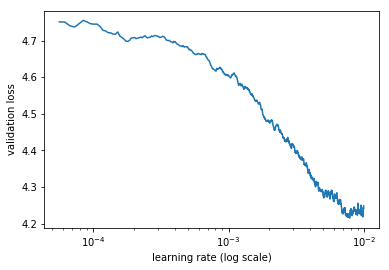

In [41]:
learner.sched.plot()

In [42]:
lrs=1e-2

In [43]:
learner.fit(lrs, 1, wds=wd, use_clr=(20,10), cycle_len=15)

epoch      trn_loss   val_loss   accuracy                     
    0      4.195465   4.023378   0.297113  
    1      4.124047   3.969857   0.301403                     
    2      4.044492   3.899156   0.308758                     
    3      3.978928   3.851844   0.314386                     
    4      3.938721   3.816191   0.317795                     
    5      3.898596   3.785243   0.321737                     
    6      3.860259   3.759675   0.323869                     
    7      3.825177   3.738404   0.327346                     
    8      3.81658    3.715246   0.329614                     
    9      3.784686   3.695854   0.332123                     
    10     3.752295   3.678986   0.333944                     
    11     3.71763    3.658768   0.335969                     
    12     3.693605   3.647004   0.337413                     
    13     3.666613   3.63081    0.33946                      
    14     3.625274   3.624469   0.340657                     



[3.624469256160235, 0.34065684555756925]

We save the trained model weights and separately save the encoder part of the LM model as well. This will serve as our backbone in the classification task model.

In [44]:
learner.save('lm_yahoo')

In [45]:
learner.save_encoder('lm_yahoo_enc')

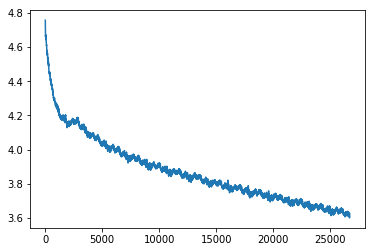

In [46]:
learner.sched.plot_loss()

## Classifier

Now we can create our final model, a classifier which is really a custom linear head over our trained LM backbone. The steps to create the classifier model are similar to the ones for the LM.

In [47]:
trn_clas = np.load(LM_PATH/'tmp'/'trn_ids.npy')
val_clas = np.load(LM_PATH/'tmp'/'val_ids.npy')
itos = pickle.load(open(LM_PATH/'tmp'/'itos.pkl', 'rb'))
trn_labels = np.array(trn_labels)
val_labels = np.array(val_labels)

In [48]:
bptt,em_sz,nh,nl = 70,200,500,3
vs = len(itos)
opt_fn = partial(optim.Adam, betas=(0.8, 0.99))
bs = 48

In [49]:
min_lbl = trn_labels.min()
trn_labels -= min_lbl
val_labels -= min_lbl
c=int(trn_labels.max())+1

The sortishSampler cuts down the overall number of padding tokens the classifier ends up seeing.

In [50]:
trn_ds = TextDataset(trn_clas, trn_labels)
val_ds = TextDataset(val_clas, val_labels)
trn_samp = SortishSampler(trn_clas, key=lambda x: len(trn_clas[x]), bs=bs//2)
val_samp = SortSampler(val_clas, key=lambda x: len(val_clas[x]))
trn_dl = DataLoader(trn_ds, bs//2, transpose=True, num_workers=1, pad_idx=1, sampler=trn_samp)
val_dl = DataLoader(val_ds, bs, transpose=True, num_workers=1, pad_idx=1, sampler=val_samp)
md = ModelData(PATH, trn_dl, val_dl)

In [51]:
dps = np.array([0.4,0.5,0.05,0.3,0.4])*0.5

In [52]:
m = get_rnn_classifier(bptt, 20*70, c, vs, emb_sz=em_sz, n_hid=nh, n_layers=nl, pad_token=1,
          layers=[em_sz*3, 50, c], drops=[dps[4], 0.1],
          dropouti=dps[0], wdrop=dps[1], dropoute=dps[2], dropouth=dps[3])

In [53]:
opt_fn = partial(optim.Adam, betas=(0.7, 0.99))

In [54]:
learn = RNN_Learner(md, TextModel(to_gpu(m)), opt_fn=opt_fn)
learn.reg_fn = partial(seq2seq_reg, alpha=2, beta=1)
learn.clip=25.
learn.metrics = [accuracy]

In [55]:
lr=3e-3
lrm = 2.6
lrs = np.array([lr/(lrm**4), lr/(lrm**3), lr/(lrm**2), lr/lrm, lr])

In [56]:
wd = 1e-7
#wd = 0
learn.load_encoder('lm_yahoo_enc')

In [57]:
learn.freeze_to(-1)

 80%|███████▉  | 1140/1432 [01:48<00:27, 10.47it/s, loss=1.81] 

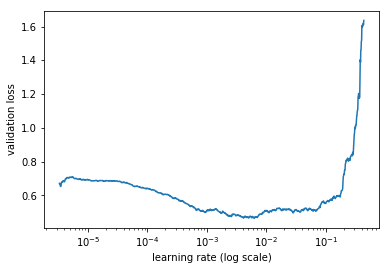

In [58]:
learn.lr_find(lrs/1000)
learn.sched.plot()

In [59]:
lrs=np.array([1e-3,1e-3,1e-3,1e-3,1e-2])

In [60]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.471516   0.364929   0.845247  


[0.3649292613283818, 0.8452474449154718]

In [61]:
learn.save('yahoo_clas_0')

In [62]:
learn.load('yahoo_clas_0')

In [63]:
learn.freeze_to(-2)

In [64]:
learn.fit(lrs, 1, wds=wd, cycle_len=1, use_clr=(8,3))

epoch      trn_loss   val_loss   accuracy                      
    0      0.389495   0.304517   0.870385  


[0.30451693976384303, 0.8703849144742326]

In [65]:
learn.save('yahoo_clas_1')

In [66]:
learn.load('yahoo_clas_1')

In [67]:
learn.unfreeze()

In [68]:
learn.fit(lrs, 1, wds=wd, cycle_len=14, use_clr=(32,5))

epoch      trn_loss   val_loss   accuracy                      
    0      0.344056   0.282968   0.874574  
    1      0.306216   0.264631   0.892904                      
    2      0.282492   0.261496   0.894475                      
    3      0.258842   0.249208   0.895261                      
    4      0.211831   0.235028   0.9094                        
    5      0.209842   0.240068   0.9094                        
    6      0.195876   0.250132   0.910448                      
    7      0.173494   0.273665   0.908877                      
    8      0.146501   0.304855   0.908091                      
    9      0.134528   0.274679   0.909139                      
    10     0.126052   0.280292   0.908353                      
    11     0.120455   0.280911   0.910186                      
    12     0.13258    0.282402   0.909662                       
    13     0.104219   0.301203   0.909924                       


[0.3012027806029578, 0.9099240674339498]

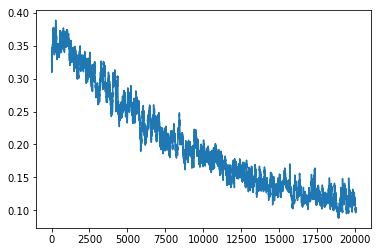

In [69]:
learn.sched.plot_loss()

In [70]:
learn.save('yahoo_clas_2')

## Fin

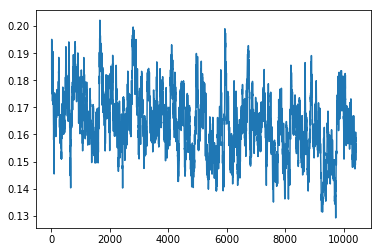

In [25]:
learn.sched.plot_loss()